# Main Code Modifications
- Cleaning data:
    - Removed rows without relevant information
    - Drop duplicates
    - Remove digits
- Add Elbow method for number of clusters
- Added TSNE visualization of document representations using `bokeh`
- Checkpoint at the end

**OBS.: All the dependencies are added in the `requirements.txt`. Just run the command below.**

In [1]:
!pip install -r requirements.txt -U

Requirement already up-to-date: ipython>=7.4.0 in d:\miniconda\envs\testing\lib\site-packages (from -r requirements.txt (line 1)) (7.5.0)
Requirement already up-to-date: jupyter>=1.0.0 in d:\miniconda\envs\testing\lib\site-packages (from -r requirements.txt (line 2)) (1.0.0)
  Using cached https://files.pythonhosted.org/packages/7d/2f/de96d3f6f43cec07efc6f8f24fddf176e9a119f23aab8fe6153f2e96c6d3/bokeh-1.2.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/45/af/685bf3ce889ea191f3b916557f5677cc95a5e87b2fa120d74b5dd6d049d0/tqdm-4.32.1-py2.py3-none-any.whl
Requirement already up-to-date: ipywidgets>=7.2.1 in d:\miniconda\envs\testing\lib\site-packages (from -r requirements.txt (line 11)) (7.4.2)
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/d9/3ec19e966301a6e25769976999bd7bbe552016f0d32b577dc9d63d2e0c49/pyparsi

O sistema nÆo pode encontrar o caminho especificado.


# Clustering Documents

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import string
import pickle
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Added Bokeh for dynamic plot
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category20 as Palette

## Load and Inspect the Data

In [2]:
# Loading and inpecting the data
data = pd.read_csv('export_htmlcontent_04162019_en.csv')
print(data.shape)
data.head()

(1563, 3)


,collectdate,daily_url,html_content
0,2018-08-18,https://www.fairfieldcurrent.com/2018/08/18/fi...,l (VDSI). usand blog and news sources in re...
1,2018-11-30,https://www.fayettecountyrecord.com/articles/2...,
2,2018-11-30,https://austinfilmschool.org/calendar/2018/11/...,
3,2018-11-30,https://www.washingtonpost.com/politics/2018/1...,y for severe misconduct. If public employees a...
4,2018-11-30,https://www.federaltimes.com/opinions/2018/11/...,"of public services. Further, young workers of..."


## Clean Data

- Missing values
- Duplicates

In [3]:
# Remove leading and trailing spaces
data.html_content = data.html_content.str.strip()
# Remove numbers from text
data.html_content = data.html_content.str.replace('[0-9]', "", regex=True)
# Create a new column with the length of html_content
data["html_length"] = data.html_content.str.strip().apply(len)

# Number of entries in html content with less than 10 characters
THRESH = 10
no_info = data[data.html_length < THRESH]
# Entries with less than THRESH characters
print("Entries with less than {} characters: {}".format(THRESH, len(no_info)))
# Show these entries
no_info.sort_values("html_length", ascending=False).head(20)

Entries with less than 10 characters: 172


,collectdate,daily_url,html_content,html_length
15,2018-12-04,https://www.daily-sun.com/printversion/details...,t stake.,8
1252,2018-10-17,https://www.cnbc.com/2018/10/17/us-named-the-w...,Err:,4
1061,2018-09-20,https://www.cnbc.com/2018/09/20/reuters-americ...,Err:,4
703,2019-03-20,https://www.nypl.org/events/programs/2019/03/2...,s.,2
702,2019-03-19,https://www.nypl.org/events/programs/2019/03/1...,s.,2
701,2019-03-19,https://www.sap.com/about/events/2019-03-19-us...,s.,2
1150,2018-10-01,https://www.chamberinnewbraunfels.com/articles...,e,1
1157,2018-10-02,https://www.propertycasualty360.com/2018/10/02...,,0
1091,2018-09-24,https://www.wausauchamber.com/events/details/w...,,0
1030,2018-09-17,http://www.icoast.com/events/2018/09/17/busine...,,0


In [4]:
# Drop duplicates
data = data.drop_duplicates(["html_content"])
print(data.shape)

(1283, 4)


## Extract Text Corpus

In [5]:
# Get html_content above threshold as a list
corpus_mwa = data[data.html_length >= THRESH]['html_content'].copy()
print(corpus_mwa.shape)

# Check some entries
corpus_mwa.iloc[10]

(1278,)


'tional .K MBoe will be needed, projected to lead to +% oil demand growth to . Secondly, cost productivity: decarbonising energy supplies to meet tighter regulatory frameworks will put additional pressure on conventional energy, as they need to compete with other sources. And finally, the aging workforce. How can downstream oil & gas quickly adapt to retain knowledge built over several generations? And perhaps more challenging, how can the industry be perceived as exciting and cutting-edge, ready to develop and embrace technology to attract the brightest, most talented people? gh there is a wide variety of digital capability and expertise available, few have successfully cracked embedding digital in an industry that is renowned for its risk adverse behaviour. utions can help wherever you are in your transformation journey. rthern Europe, Martin Carruth, will participate in this event and will provide leadership during a panel discussion on the challenges and opportunities digital bring

# Create TF-ID Model

Since this calculation is fast, try other parameters could be interesting.

In [6]:
# Create TfidVectorizer
vectorizer = TfidfVectorizer(min_df = 0, max_df=0.5, stop_words = "english",
                             ngram_range = (1,1), max_features = 200)

# Get DFM - Data Frequency Matrix
X = vectorizer.fit_transform(corpus_mwa)

# Get vocabulary
vocab = vectorizer.get_feature_names()

In [7]:
# Take a look at vocab
vocab[1:10]

['access',
 'according',
 'ai',
 'america',
 'based',
 'benefits',
 'best',
 'better',
 'billion']

## Show DFM Matrix as a DataFrame

In [8]:
terms_df = pd.DataFrame(X.toarray(), columns=vocab)
terms_df.head()

,able,access,according,ai,america,based,benefits,best,better,billion,...,way,women,work,workers,workforce,working,workplace,world,year,years
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.377132,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.108439,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.217588,0.097146,0.076771,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.648375,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.091541,0.137312,0.044717,0.0,0.0,0.082163,0.0,0.0,0.0,0.0,...,0.039056,0.000000,0.336750,0.123012,0.032404,0.040177,0.0,0.116765,0.0,0.035154


In [9]:
terms_df.shape

(1278, 200)

# Scale the Bag of Words Representation

In [10]:
# MinMax Scaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(terms_df), columns=terms_df.columns)
df_scaled.head()

,able,access,according,ai,america,based,benefits,best,better,billion,...,way,women,work,workers,workforce,working,workplace,world,year,years
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.377132,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.133209,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.217588,0.121312,0.136688,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.732474,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.091541,0.168677,0.078058,0.0,0.0,0.152003,0.0,0.0,0.0,0.0,...,0.039056,0.000000,0.336750,0.153612,0.057694,0.053409,0.0,0.116765,0.0,0.035154


# Elbow Method

This [rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is used to detect the ideal number of cluster.

In [11]:
# Parameters
c0 = 1
c1 = 15
cluster_models = []

# For each ideal cluster
for c in tqdm(range(c0, c1 + 1)):
    # Calculate model
    cluster_models.append(KMeans(n_clusters=c, max_iter=600, n_jobs=-2, n_init=20).fit(df_scaled))

100%|███████████████████████████████████████████████| 15/15 [00:08<00:00,  2.13it/s]


Text(0.5, 0, 'Distortions')

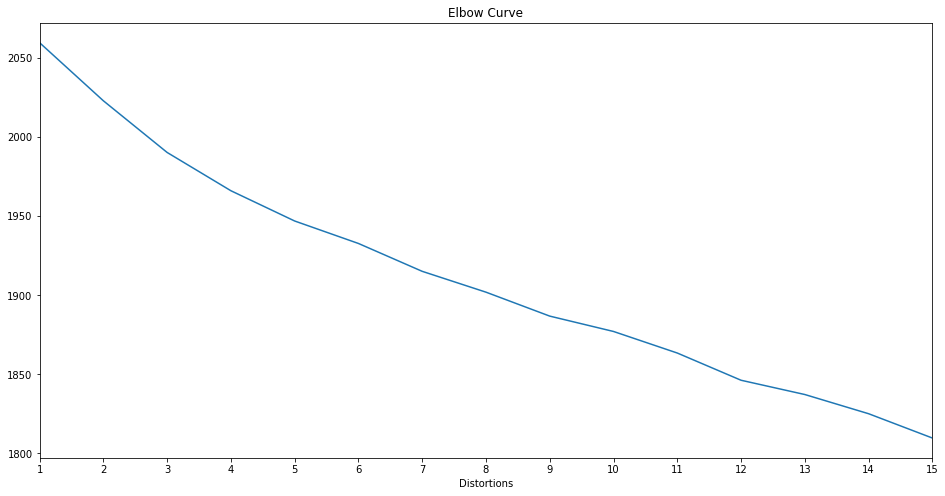

In [12]:
# Variables
x = range(c0, c1 + 1)
y = [m.inertia_ for m in cluster_models]

# Plot Elbow
plt.figure(figsize=(16, 8))
plt.plot(x, y)
plt.title("Elbow Curve")
plt.xticks(x)
plt.xlim((c0, c1))
plt.xlabel("Number of Clusters")
plt.xlabel("Distortions")

**Checking the graph there is no clear *Elbow Point*, but possible values of number of clusters could be 5, 9 or 13.**

In [13]:
# Select best model from plot
best_model = cluster_models[4]  # n_clusters = 5

# Clusters 
corpus_clusters = best_model.predict(df_scaled)

## Show Top Words per Cluster

In [14]:
print("Top terms per cluster:")
ordered_centroids = best_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
#terms.append('cost')
for i in range(best_model.n_clusters):
    print('\n')
    print(" Cluster %d:" % i ),
    for ind in ordered_centroids[i, :15]:
           print(' %s ' % terms[ind], end = ''),
    print

Top terms per cluster:


 Cluster 0:
 employees  workers  women  work  workforce  employee  people  according  percent  think  working  job  says  companies  just 

 Cluster 1:
 students  workforce  training  school  skills  education  career  college  program  opportunities  state  high  jobs  community  need 

 Cluster 2:
 com  trouble  create  performance  large  experience  free  work  learn  ve  program  early  want  based  benefits 

 Cluster 3:
 said  time  new  public  year  government  business  percent  health  people  community  state  just  years  president 

 Cluster 4:
 data  digital  customer  technologies  global  customers  companies  business  products  growth  market  technology  information  solutions  service 

## Show Document using TSNE

In [15]:
# Calculate TSNE
tsne = TSNE(n_components=2, init='pca')
projected_vector = tsne.fit_transform(df_scaled)

In [16]:
# Plot TSNE
palette = Palette[best_model.n_clusters]
x = projected_vector[:, 0]
y = projected_vector[:, 1]
colors = [palette[c] for c in corpus_clusters]
plot_df = pd.DataFrame({"X":x, "Y":y,"cluster":corpus_clusters, "C":colors,"text":corpus_mwa})
# Bokeh settings
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,save,"
TOOLTIPS = [
    ("index", "$index"),
    ("Text Content", "@text"),
    ("Cluster", "@cluster")
]
p = figure(tools=TOOLS, 
           tooltips=TOOLTIPS)
p.scatter("X", "Y", color="C", source=plot_df)
show(p)

Loading BokehJS ...

# Add Cluster Label to CSV File

In [17]:
# Load data again
dataset = pd.read_csv('export_htmlcontent_04162019_en.csv')

In [18]:
# Add cluster label
dataset["cluster"] = pd.Series(corpus_clusters, name='cluster', dtype=int)

In [19]:
dataset.head()

,collectdate,daily_url,html_content,cluster
0,2018-08-18,https://www.fairfieldcurrent.com/2018/08/18/fi...,l (VDSI). usand blog and news sources in re...,3.0
1,2018-11-30,https://www.fayettecountyrecord.com/articles/2...,,0.0
2,2018-11-30,https://austinfilmschool.org/calendar/2018/11/...,,1.0
3,2018-11-30,https://www.washingtonpost.com/politics/2018/1...,y for severe misconduct. If public employees a...,3.0
4,2018-11-30,https://www.federaltimes.com/opinions/2018/11/...,"of public services. Further, young workers of...",2.0


In [20]:
# Save new file
dataset.to_csv("dataset_with_clusters_tfid.csv")

## Save Checkpoint

In [21]:
# Save Calculation
checkpoint = {"Corpus_Data": corpus_mwa,
              "Vectorizer_Model": vectorizer,
              "KMeans_Model": best_model
             }
# Save objects
pickle.dump(checkpoint, open('checkpoint.sav', 'wb'))

## Load Checkpoint

In [22]:
# Load data from file
checkpoint = pickle.load(open('checkpoint.sav', 'rb'))

# Load varibales
corpus_mwa = checkpoint["Corpus_Data"]
vectorized_model = checkpoint["Vectorizer_Model"]
kmeans_model = checkpoint["KMeans_Model"]